# Building an ARIMA Model for a Financial Dataset

In [1]:
%pip install --user statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


### Resample the data to get weekly stock closing prices

In [4]:
df_week = df.resample('w').mean()
cols = ['close']
df_week = df_week[cols]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


### Calculate the weekly returns

In [5]:
df_week['weekly_ret'] =np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,-0.016712
2009-06-21,19.525140,-0.029358
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396


In [8]:
# drop null rows
df_week.dropna(inplace=True)

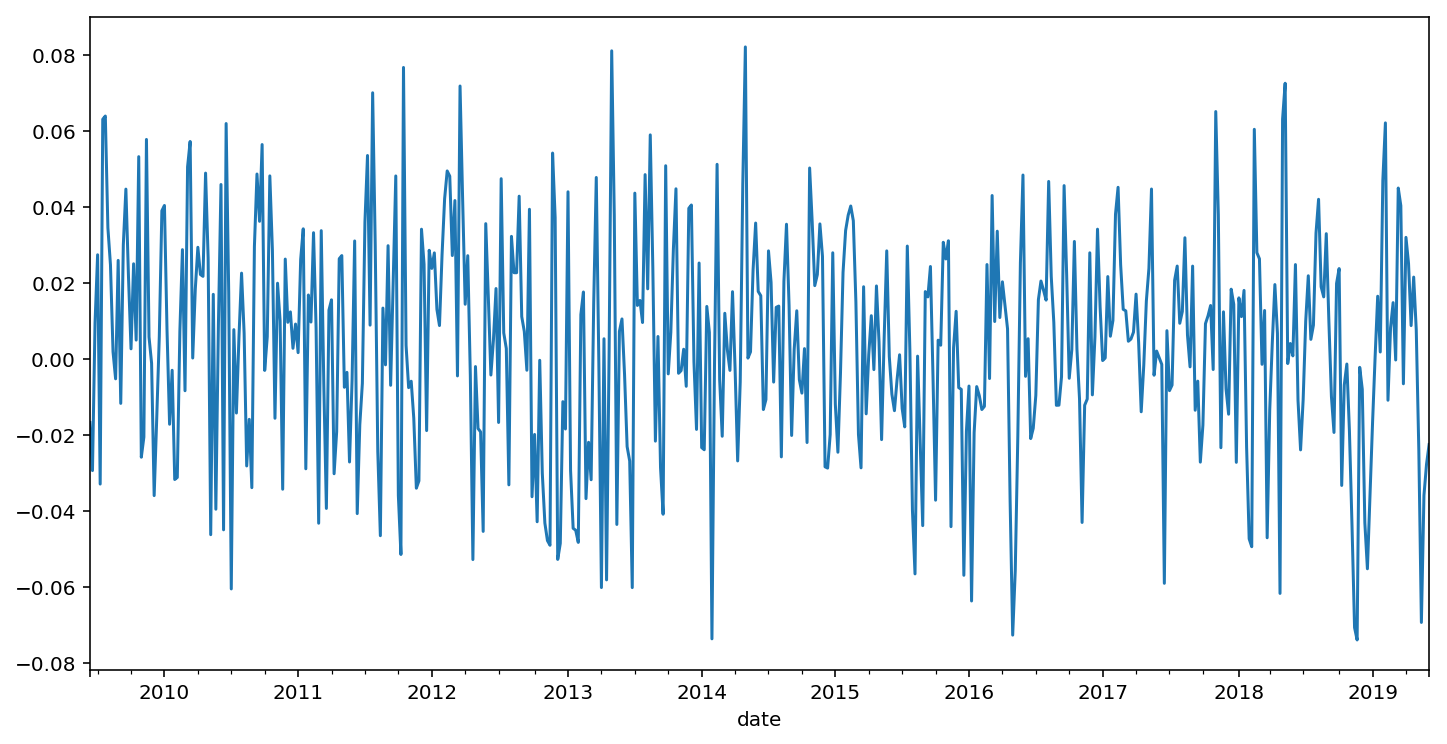

In [9]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [10]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


### Test for stationarity of the udiff series

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [12]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

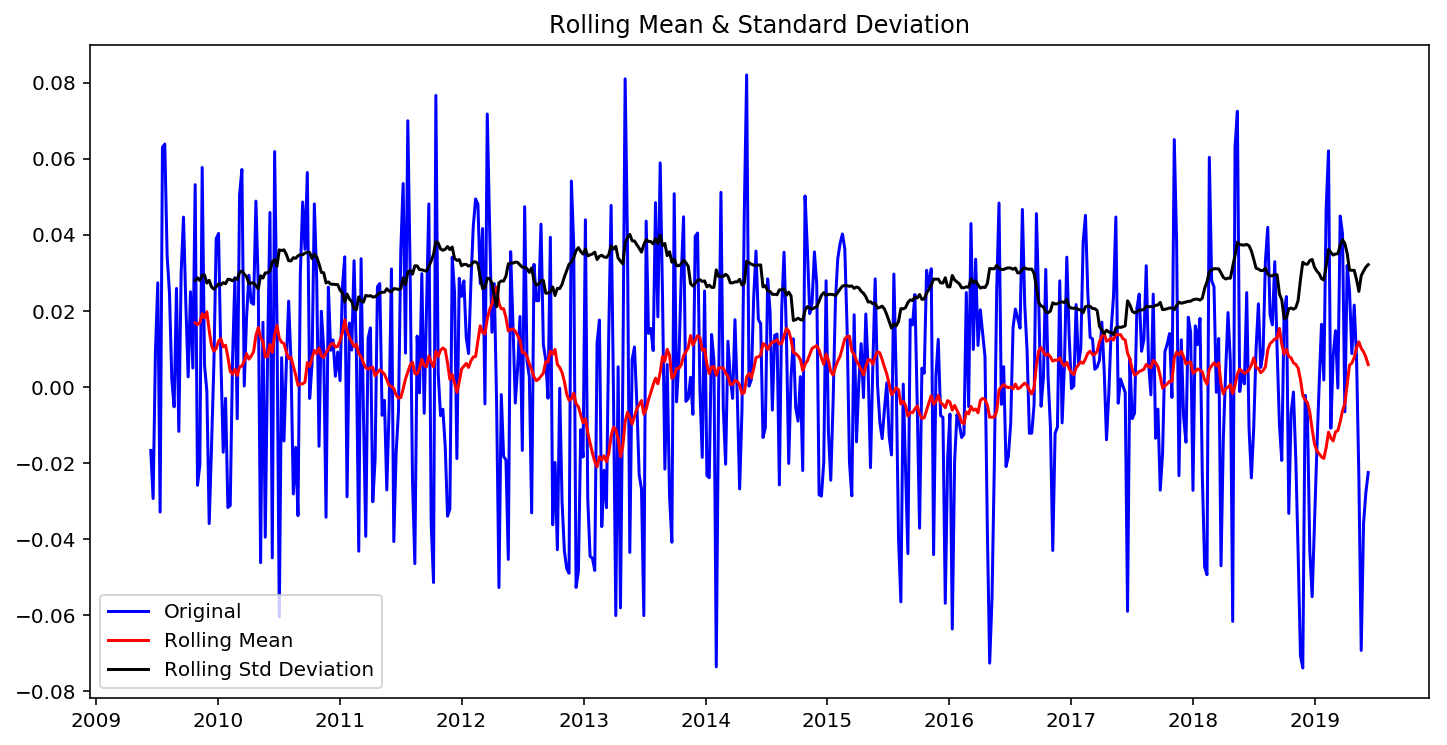

In [13]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [14]:
# Perform Dickey-Fuller test:
col = udiff.columns.values[0]
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (5%)           -2.867125e+00
Critical Value (1%)           -3.443013e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

In [15]:
# With p-value < 0.05, this data set is stationary

### ACF and PACF Charts

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of the all the "y" values in between them. 

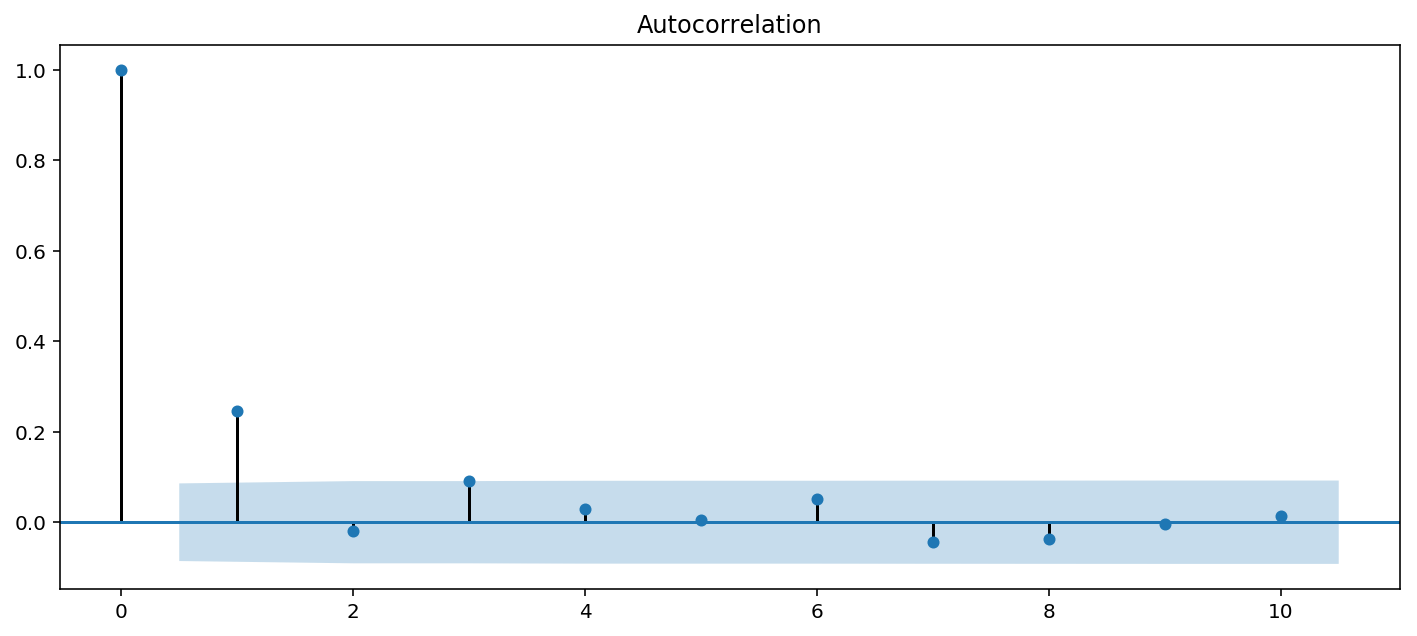

In [16]:
# from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

#The Autocorrelation Chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

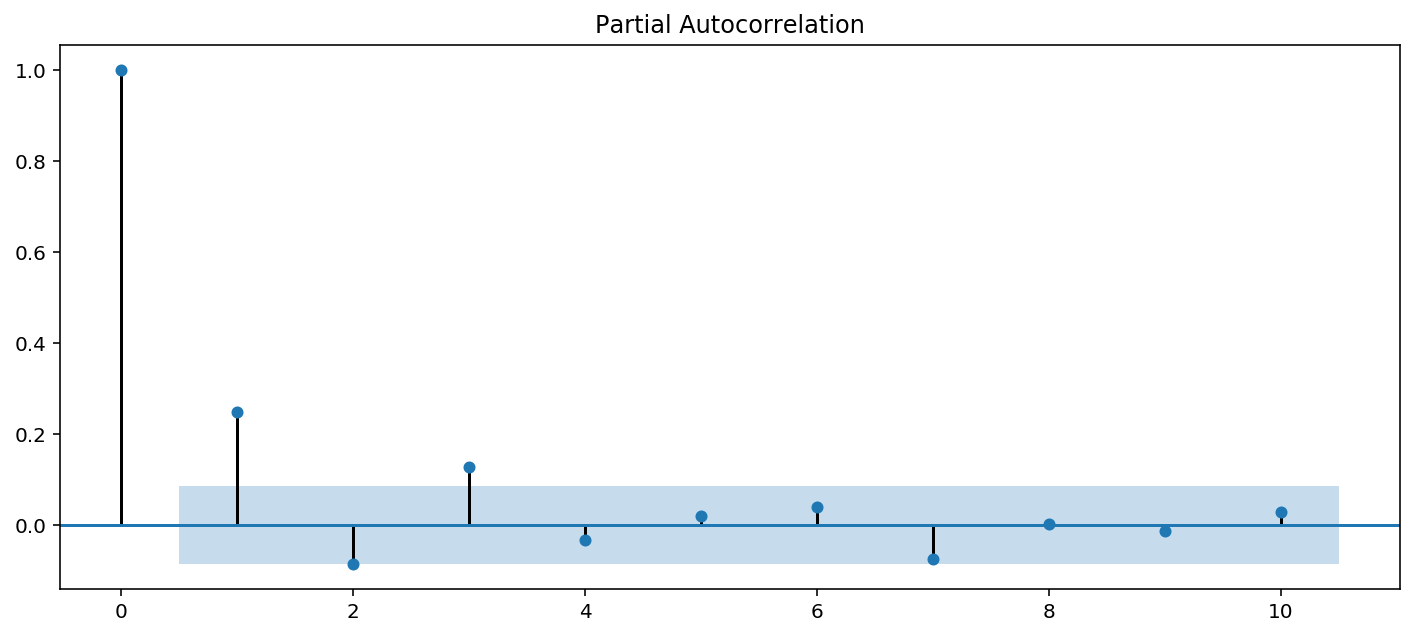

In [17]:
# from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF associated with the  AR(p)AR(p) ,  MA(q)MA(q) , and  ARMA(p,q)ARMA(p,q).

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

In [19]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data
ar1 = ARMA(tuple(udiff.values), (3, 0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                     ARMA(3, 0)   Log Likelihood                1131.319
Method:                       css-mle   S.D. of innovations              0.028
Date:                Mon, 23 Sep 2019   AIC                          -2252.638
Time:                        20:26:44   BIC                          -2231.350
Sample:                             0   HQIC                         -2244.300
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.382      0.018       0.001       0.007
ar.L1.y        0.2783      0.043      6.409      0.000       0.193       0.363
ar.L2.y       -0.1173      0.045     -2.618      0.009      -0.205      -0.029
ar.L3.y        0.1258      0.043      2.892      0.004       0.041       0.211
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9265           -0.0000j            1.9265           -0.0000
AR.2           -0.4969           -1.9698j            2.0315           -0.2893
AR.3           -0.4969           +1.9698j            2.0315            0.2893
-----------------------------------------------------------------------------
"""

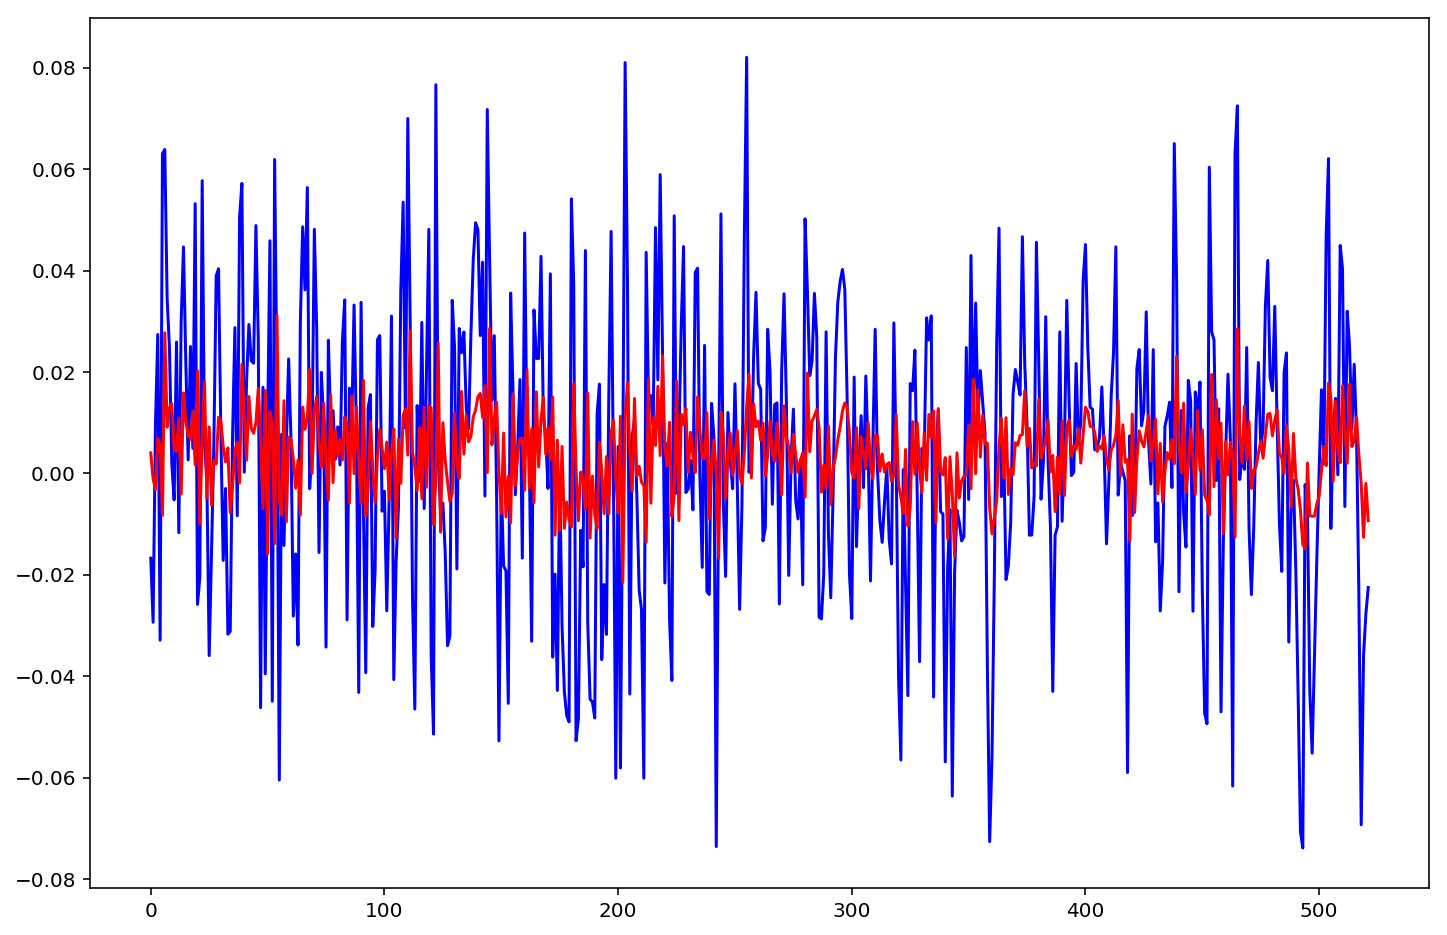

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color = 'blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

### Let's make a forecast 2 weeks ahead

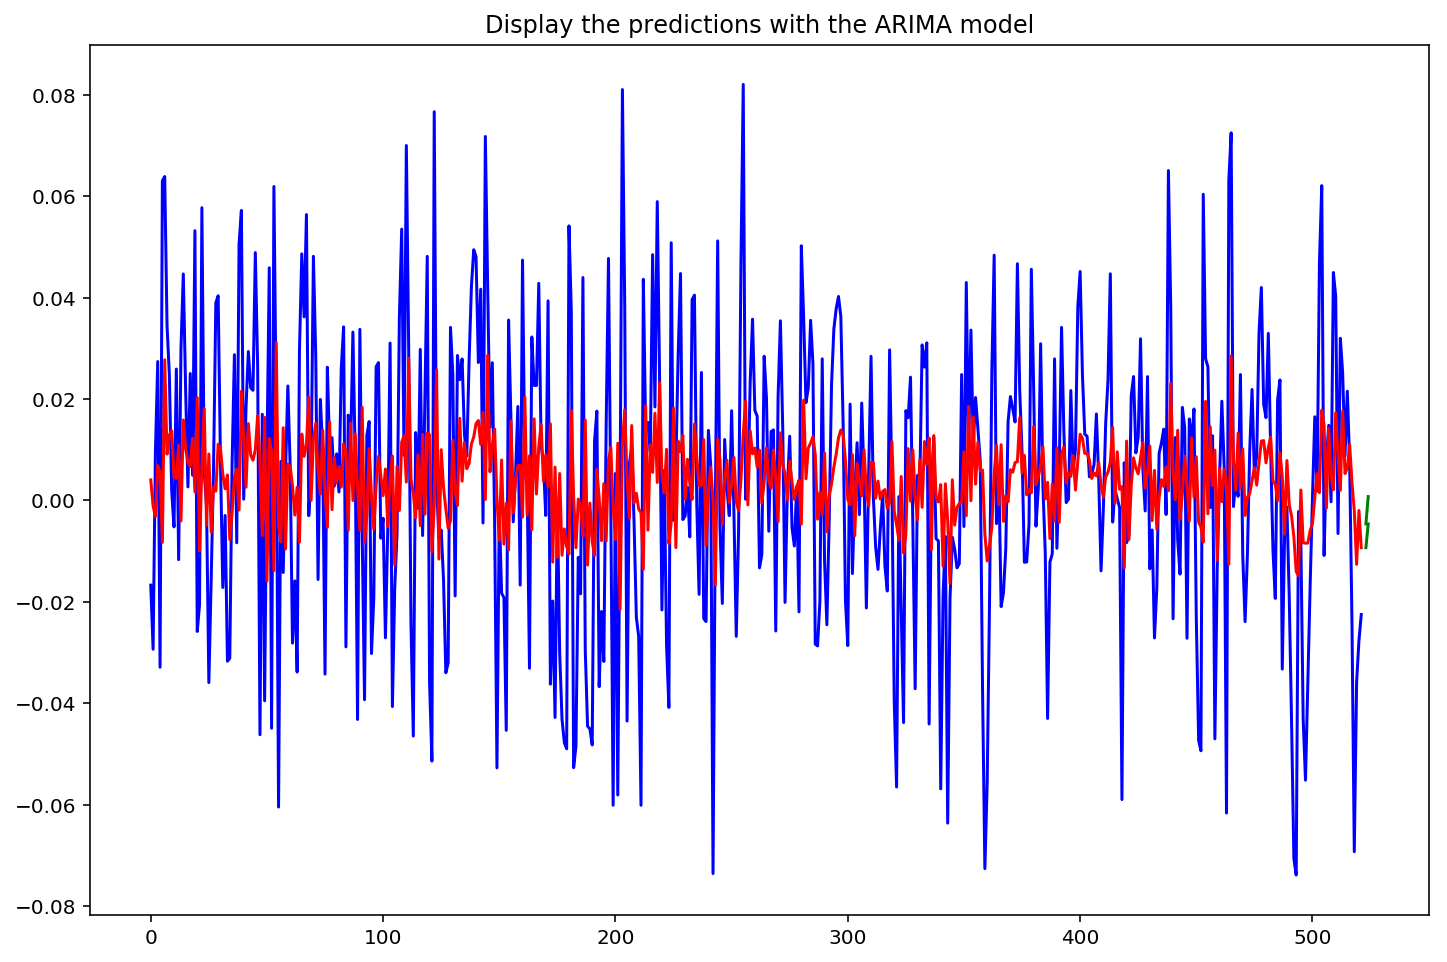

In [21]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color = 'blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1,
                                    len(udiff.values)+3)),color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1,
                                    len(udiff.values)+1+steps)),color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.